In [33]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import tensorflow_io as tfio

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import scipy.signal as signal

import time

# tf.config.run_functions_eagerly(True)

In [34]:
f_signal = 10200

curDir = str(os.getcwd())

seed = int(time.time())

In [35]:
esc50_csv = curDir+ r'\src\classification\datasets\ESC-50\meta\esc50.csv'
base_data_path = curDir+ r'\src\classification\datasets\ESC-50\audio'

pd_data = pd.read_csv(esc50_csv)

my_classes = ['chainsaw', 'crackling_fire', 'fireworks', 'gun']
map_class_to_id  = {label: idx for idx, label in enumerate(my_classes)}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

"""
unknown_pd = pd_data[~pd_data.category.isin(my_classes)]

unknown_pd = unknown_pd.assign(target=5)

# reduce the number of unknown samples to balance the dataset

unknown_pd = unknown_pd.sample(frac=40/1800, random_state=int(time.time()))

filtered_pd = pd.concat([filtered_pd, unknown_pd])
"""

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

"""
IR_path = curDir + '\classification\src\classification\datasets\ESC-50\IR'

IR_files = os.listdir(IR_path)
IR_files = [os.path.join(IR_path, file) for file in IR_files]

IR_files = tf.convert_to_tensor(IR_files)

IR_ds = tf.data.Dataset.from_tensor_slices(IR_files)
"""

background_path = str(curDir + r'\src\classification\datasets\soundfiles\background.wav')

background_ds = tf.data.Dataset.from_tensor_slices([background_path])

In [36]:
@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=f_signal)
    return wav

@tf.function
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

def convolve(x, y):
  return signal.convolve(x, y, mode='same').astype(np.float32)
"""
@tf.function
def apply_IR(wav, label, fold):
  IR = IR_ds.shuffle(buffer_size=1000).take(1)
  IR = next(iter(IR))
  wav = tf.numpy_function(convolve, [wav, IR], tf.float32)
  return wav, label, fold
"""
@tf.function
def apply_time_shift(wav, label, fold):
  if len(wav) < 20*512:
    sig = tf.zeros(20*512, dtype=tf.float32)
    shift = tf.random.uniform(shape=[], minval=0, maxval=20*512 - len(wav), dtype=tf.int32)
    sig = tf.concat([sig[:shift], wav, sig[shift+len(wav):]], 0)
    return sig, label, fold
  else:
    shift = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(wav)[0] - 20*512, dtype=tf.int32)
    wav = wav[shift:shift+20*512]
    return wav, label, fold

@tf.function
def apply_bandpass(wav, label, fold):
  filter = signal.butter(10, [500, 5000], btype='bandpass', fs=f_signal, output='sos')
  wav = tf.numpy_function(lambda x: signal.sosfilt(filter, x).astype(np.float32), [wav], tf.float32)
  return wav, label, fold


@tf.function
def apply_echo(wav, label, fold):
  shift = tf.random.uniform(shape=[], minval=0, maxval=1024, dtype=tf.int32)
  echo = tf.roll(wav, shift=shift, axis=0)
  amplitude = tf.random.uniform(shape=[], minval=0.05, maxval=0.1, dtype=tf.float32)
  echo = echo * amplitude
  return wav + echo, label, fold


@tf.function
def apply_noise(wav, label, fold):
  # get wav energy
  energy = tf.reduce_sum(wav ** 2) / tf.cast(tf.size(wav), tf.float32)
  # add gaussian noise
  noise = tf.random.normal(tf.shape(wav), mean = 0.0, stddev = energy, dtype=tf.float32)
  return wav + noise, label, fold

@tf.function
def apply_background(wav, label, fold):
  background = background_ds.take(1)
  background = next(iter(background))
  background = tf.roll(background, shift=tf.random.uniform(shape=[], minval=0, maxval=tf.shape(background)[0] - tf.shape(wav)[0], dtype=tf.int32), axis=0)
  background = background[:tf.shape(wav)[0]]
  amplitude = tf.random.uniform(shape=[], minval=0.05, maxval=0.2, dtype=tf.float32)
  background = background * amplitude
  return wav + background, label, fold

@tf.function
def wav2spec(wav, label, fold):
  spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=256, stride=512)
  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(spectrogram, rate=12000, mels=24, fmin=0, fmax=6000)
  mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)  # Ensure 3 dimensions
  mel_spectrogram = tf.image.rot90(mel_spectrogram, k=-1)
  return mel_spectrogram, label, fold

@tf.function
def float_to_quint16(spec, label, fold):
  return tf.cast(spec, tf.uint16), label, fold

@tf.function
def is_validation(fold):
  return fold == 1

@tf.function
def is_test(fold):
  return fold == 2

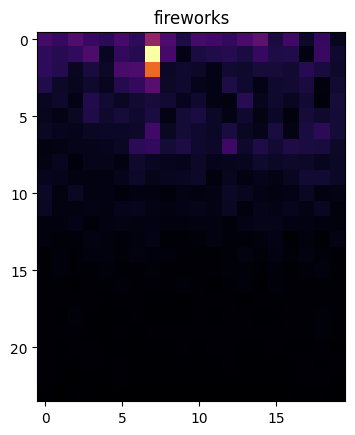

In [37]:
# IR_ds = IR_ds.map(load_wav_16k_mono)

main_ds = main_ds.map(load_wav_for_map)

# apply impulse response to the audio data
# main_ds_IR = main_ds.map(apply_IR)
# main_ds = main_ds.concatenate(main_ds_IR)

# apply time shift to the audio data

main_ds_time_shift_1 = main_ds.map(apply_time_shift)
main_ds_time_shift_2 = main_ds.map(apply_time_shift)
main_ds_time_shift_3 = main_ds.map(apply_time_shift)
main_ds_time_shift_4 = main_ds.map(apply_time_shift)

main_ds = main_ds_time_shift_1
main_ds = main_ds.concatenate(main_ds_time_shift_2)
main_ds = main_ds.concatenate(main_ds_time_shift_3)
main_ds = main_ds.concatenate(main_ds_time_shift_4)

# main_ds_bandpass = main_ds.map(apply_bandpass)
# main_ds = main_ds.concatenate(main_ds_bandpass)

#main_ds_echo = main_ds.map(apply_echo)
#main_ds = main_ds.concatenate(main_ds_echo)

"""
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (wav, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.plot(wav.numpy())
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()
"""

background_ds = background_ds.map(load_wav_16k_mono)

#main_ds = main_ds.map(apply_background)
# main_ds = main_ds.concatenate(main_ds_background)

main_ds_noise = main_ds.map(apply_noise)
main_ds = main_ds.concatenate(main_ds_noise)

"""
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (wav, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.plot(wav.numpy())
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()
"""

# apply a melspectrogram transformation to the audio data
main_ds = main_ds.map(wav2spec)

# main_ds = main_ds.map(float_to_quint16)

spec, label, fold = next(iter(main_ds.take(1)))
plt.imshow(spec.numpy(), cmap='inferno')
plt.title(my_classes[label.numpy()])
plt.show()
"""
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (spec, label, fold) in enumerate(main_ds.take(16)):
  r, c = i // 4, i % 4
  ax = axes[r, c]
  ax.imshow(spec.numpy(), cmap='inferno')
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()

file1 = np.load("classification/data/melspecs/0005001a00.npy")
plt.imshow(file1.reshape(20, 20), cmap='inferno')
plt.show()
"""

# split the dataset into training and validation sets

train_ds = main_ds.filter(lambda wav, label, fold: not is_validation(fold) and not is_test(fold))
val_ds = main_ds.filter(lambda wav, label, fold: is_validation(fold))
test_ds = main_ds.filter(lambda wav, label, fold: is_test(fold))

# shuffle the training dataset

train_ds = train_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed = seed)

# batch the datasets

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

# prepare the datasets for training

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:

# build the model

@tf.function
def normalize(x):
  return x / tf.reduce_max(x)

def build_model(input_shape):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))
  model.add(tf.keras.layers.Lambda(normalize))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(4, activation='softmax'))
  return model

input_shape = (24, 20, 1)

model_path = curDir + r'\data\models\four.keras'

new_model = False

if not new_model:
  model = tf.keras.models.load_model(model_path, custom_objects={'normalize': normalize})
else:
  model = build_model(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        weighted_metrics=[])
        
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 24, 20, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 20, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 12, 10, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 10, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 5, 32)         0         
 2D)                                                  

10/10 [==============================] - 13s 1s/step - loss: 2.7982 - accuracy: 0.4906
Test accuracy: 0.4906249940395355
1/1 [==============================] - 0s 23ms/step


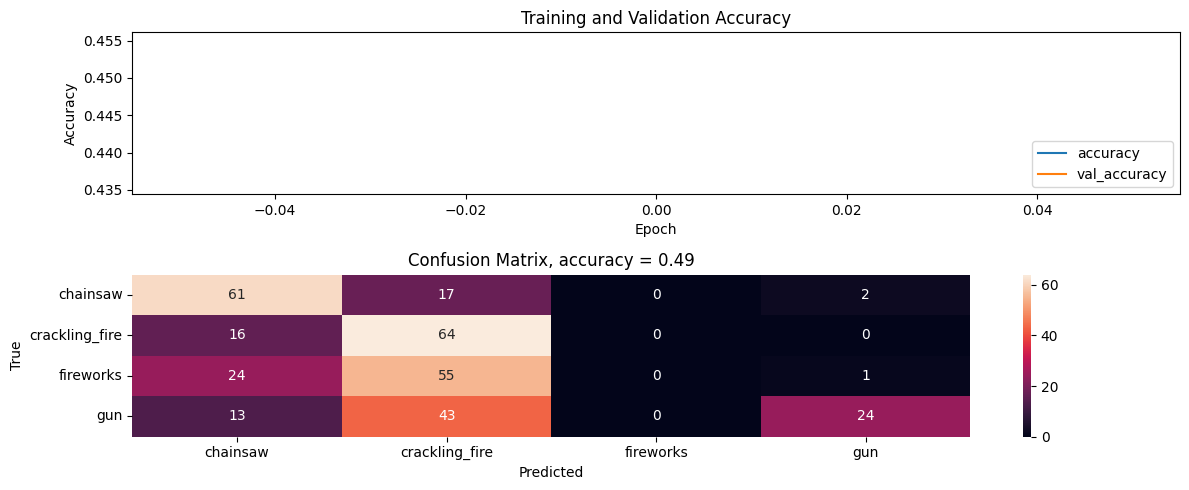

In [39]:
# train the model

history = model.fit(train_ds, validation_data=val_ds, epochs=1)

model.save(model_path)

# evaluate the model

loss, accuracy = model.evaluate(test_ds)

print(f'Test accuracy: {accuracy}')

# plot the confusion matrix

y_true = []
y_pred = []

for x, y, _ in test_ds:
  y_true.extend(y)
  y_pred.extend(model.predict(x))
y_true = np.array(y_true)
y_pred = np.argmax(np.array(y_pred), axis=1)

cm = confusion_matrix(y_true, y_pred)

# plot the training history

fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Plot the training history
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_title('Training and Validation Accuracy')

# Plot the confusion matrix
heatmap(cm, annot=True, xticklabels=my_classes, yticklabels=my_classes, ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
ax[1].set_title('Confusion Matrix, accuracy = {:.2f}'.format(accuracy))

plt.tight_layout()
plt.show()

In [40]:
"""
fm_dir = "classification/data/feature_matrices/"

file1 = np.load(fm_dir + "../melspecs/0005001a00.npy")
file2 = np.load(fm_dir + "../melspecs/0002001900.npy")
file3 = np.load(fm_dir + "../melspecs/0004001500.npy")
file4 = np.load(fm_dir + "../melspecs/0004001900.npy")
file5 = np.load(fm_dir + "../melspecs/0005000700.npy")
file6 = np.load(fm_dir + "../melspecs/0005001200.npy")
file7 = np.load(fm_dir + "../melspecs/0005002200.npy")
file8 = np.load(fm_dir + "../melspecs/0017002200.npy")
file9 = np.load(fm_dir + "../melspecs/0026000000.npy")

y_aug = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

X_aug = [file1.reshape(20,20,1), file2.reshape(20,20,1), file3.reshape(20,20,1), file4.reshape(20,20,1), file5.reshape(20,20,1), file6.reshape(20,20,1), file7.reshape(20,20,1), file8.reshape(20,20,1), file9.reshape(20,20,1)]

X_aug = tf.constant(X_aug)

# Ensure the input has the correct dimensions

y_pred = model.predict(X_aug).argmax(axis=1)
print (y_pred) 

# Plot the confusion matrix

cm = confusion_matrix(y_aug, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the confusion matrix

heatmap(cm, annot=True, xticklabels=my_classes, yticklabels=my_classes, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
"""

'\nfm_dir = "classification/data/feature_matrices/"\n\nfile1 = np.load(fm_dir + "../melspecs/0005001a00.npy")\nfile2 = np.load(fm_dir + "../melspecs/0002001900.npy")\nfile3 = np.load(fm_dir + "../melspecs/0004001500.npy")\nfile4 = np.load(fm_dir + "../melspecs/0004001900.npy")\nfile5 = np.load(fm_dir + "../melspecs/0005000700.npy")\nfile6 = np.load(fm_dir + "../melspecs/0005001200.npy")\nfile7 = np.load(fm_dir + "../melspecs/0005002200.npy")\nfile8 = np.load(fm_dir + "../melspecs/0017002200.npy")\nfile9 = np.load(fm_dir + "../melspecs/0026000000.npy")\n\ny_aug = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])\n\nX_aug = [file1.reshape(20,20,1), file2.reshape(20,20,1), file3.reshape(20,20,1), file4.reshape(20,20,1), file5.reshape(20,20,1), file6.reshape(20,20,1), file7.reshape(20,20,1), file8.reshape(20,20,1), file9.reshape(20,20,1)]\n\nX_aug = tf.constant(X_aug)\n\n# Ensure the input has the correct dimensions\n\ny_pred = model.predict(X_aug).argmax(axis=1)\nprint (y_pred) \n\n# Plot the confusi